<a href="https://colab.research.google.com/github/psmouli14/final_project/blob/main/Cifar_prototype_reptile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz


In [ ]:
!tar -zxvf cifar-100-python.tar.gz

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [ ]:
meta = unpickle('cifar-100-python/meta')
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

In [ ]:
meta_keys = list(meta.keys())
meta_keys

[b'fine_label_names', b'coarse_label_names']

In [ ]:
Classes = pd.DataFrame(meta[b'fine_label_names'],columns = ['Classes'])

In [ ]:
len(Classes)

100

In [ ]:
Classes

,Classes
0,b'apple'
1,b'aquarium_fish'
2,b'baby'
3,b'bear'
4,b'beaver'
...,...
95,b'whale'
96,b'willow_tree'
97,b'wolf'
98,b'woman'


In [ ]:
training_keys = list(train.keys())
training_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [ ]:
test_keys = list(test.keys())
test_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [ ]:
train_images = train[b'data']
test_images = test[b'data']
train_images.shape


(50000, 3072)

In [ ]:
test_images.shape

(10000, 3072)

In [ ]:
img_num = np.random.randint(0,1000)
print(img_num)
Classes.iloc[train[b'fine_labels'][0]]

927


Classes    b'cattle'
Name: 19, dtype: object

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
train_images = train_images.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
train_images = tf.cast(train_images, tf.float32)
train_images.shape
train_images = train_images/255
train_images[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7647059 , 0.8039216 , 0.75686276],
        [0.83137256, 0.8784314 , 0.8       ],
        [0.7137255 , 0.7607843 , 0.654902  ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.6666667 , 0.6901961 , 0.5882353 ],
        [0.6313726 , 0.65882355, 0.50980395],
        [0.57254905, 0.6039216 , 0.44313726]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7411765 , 0.78039217, 0.6627451 ],
        [0.6509804 , 0.69803923, 0.50980395],
        [0.4745098 , 0.52156866, 0.34117648]],

       ...,

       [[0.5803922 , 0.7254902 , 0.30980393],
        [0.5568

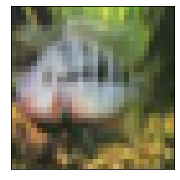

In [ ]:
plt.figure(figsize=(6,3))
plt.xticks([])
plt.yticks([])
plt.imshow(train_images[4])

In [ ]:
print(train[b'fine_labels'][49000])

4


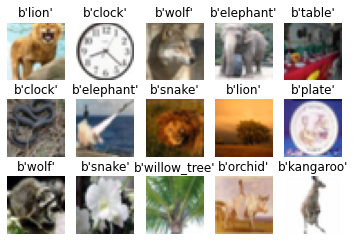

In [ ]:
num_images_row = 3
num_images_column = 5
img_nums = np.random.randint(0,len(train_images),num_images_row*num_images_column)

f, axarr = plt.subplots(num_images_row,num_images_column)

for i in range(0,num_images_row):
    for j in range(0,num_images_column):
        axarr[i,j].imshow(train_images[img_nums[(i*num_images_column)+j]])
        axarr[i,j].set_title(str(Classes.iloc[train[b'fine_labels'][img_nums[(i+1)*(j+1)-1]]]).split()[1])
        axarr[i,j].axis('off')

In [ ]:
test_images = test_images.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_images = tf.cast(test_images, tf.float32)
test_images.shape
test_images = test_images/255
test_images[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.78039217, 0.84313726, 0.9764706 ],
        [0.76862746, 0.827451  , 0.95686275],
        [0.7647059 , 0.8235294 , 0.9529412 ],
        ...,
        [0.84705883, 0.90588236, 0.98039216],
        [0.8509804 , 0.90588236, 0.98039216],
        [0.8784314 , 0.91764706, 0.9882353 ]],

       [[0.77254903, 0.8235294 , 0.9372549 ],
        [0.7647059 , 0.8156863 , 0.93333334],
        [0.7647059 , 0.8235294 , 0.9411765 ],
        ...,
        [0.90588236, 0.9529412 , 0.98039216],
        [0.9137255 , 0.9529412 , 0.98039216],
        [0.94509804, 0.9607843 , 0.99215686]],

       [[0.87058824, 0.8862745 , 0.9647059 ],
        [0.8352941 , 0.8627451 , 0.9490196 ],
        [0.81960785, 0.85882354, 0.9529412 ],
        ...,
        [0.9529412 , 0.98039216, 0.9843137 ],
        [0.95686275, 0.9764706 , 0.9843137 ],
        [0.98039216, 0.98039216, 0.99215686]],

       ...,

       [[0.28235295, 0.28627452, 0.3882353 ],
        [0.2784

In [ ]:
# Now we build the labels and images as lists
train_labels = train[b'fine_labels']
test_labels = test[b'fine_labels']

In [ ]:
test_labels[0:100]

In [ ]:
len(train_labels), len(test_labels)

(50000, 10000)

In [ ]:
num_ways = [5, 5, 12, 12, 15]
num_shots = [5, 1, 5, 1, 3]
learning_rate = 0.001
img_width = 32
img_height = 32
channels = 3
learning_rate = 0.001
num_classes = 100

In [ ]:
print(test_images.shape)
print(train_images.shape)
print(train_labels[0:80])


(10000, 32, 32, 3)
(50000, 32, 32, 3)
[19, 29, 0, 11, 1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39, 8, 97, 80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64, 8, 17, 47, 65, 21, 22, 81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87, 9, 71, 6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50, 15, 89, 36, 18, 89, 46, 33, 42]


In [ ]:
#split train into train and val
train_images_split = np.zeros([40000, img_width , img_height, channels], dtype=np.float32)
val_images_split = np.zeros([10000, img_width , img_height, channels], dtype=np.float32)
train_labels_split = np.zeros(40000)
val_labels_split = np.zeros(10000)

train_split = 400
val_split = 100
for class_ in range(len(Classes)):
  train_start_index = class_ * 500
  train_end_index = train_start_index + train_split
  train_index = class_ * train_split
  val_start_index = train_end_index
  val_end_index = val_start_index + val_split
  val_index = class_ * val_split

  train_images_split[train_index : train_index + train_split] = train_images[train_start_index: train_end_index]
  val_images_split[val_index : val_index + val_split] = train_images[val_start_index : val_end_index]


  train_labels_split[train_index : train_index + train_split] = train_labels[train_start_index : train_end_index]
  val_labels_split[val_index : val_index + val_split] = train_labels[val_start_index : val_end_index]


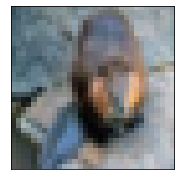

In [ ]:
plt.figure(figsize=(6,3))
plt.xticks([])
plt.yticks([])
plt.imshow(train_images_split[34009])

In [ ]:
def get_next_batch(dataset, labels, num_way, num_shot, num_query, no_of_classes):
  episodic_classes = np.random.permutation(no_of_classes)[:num_way]
  support = np.zeros([num_way, num_shot, img_width , img_height, channels], dtype=np.float32)
  query = np.zeros([num_way, num_query, img_width , img_height, channels], dtype=np.float32)

  for index, class_ in enumerate(episodic_classes):
    indices = find_indices(labels, class_)
    #check that the size is greater than num_shot + num_query
    selected = np.random.permutation(indices)[:num_shot + num_query]
    for support_index in range(num_shot):
       support[index][support_index] = dataset[selected[support_index]] 
    for query_index in range(num_query):
       query[index][query_index] = dataset[selected[num_shot + query_index]]  
    
  return support, query

def find_indices(list_to_check, item_to_find):
  indices = []
  for idx, value in enumerate(list_to_check):
    if value == item_to_find:
      indices.append(idx)
  return indices



In [ ]:
support, query = get_next_batch(val_images_split, val_labels_split, 20, 7, 3, 100)

In [ ]:
support.shape

(20, 7, 32, 32, 3)

In [ ]:
query.shape

(20, 3, 32, 32, 3)

In [ ]:
def show_image(dataset, index, image_number):
  plt.figure(figsize=(2,3))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(dataset[index][image_number])


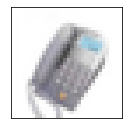

In [ ]:
show_image(support, 4, 6)

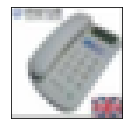

In [ ]:
show_image(query, 4, 0)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras import Model

class Prototypical(Model):
    """
    Implemenation of Prototypical Network.
    """
    def __init__(self, n_support, n_query, w, h, c):
        """
        Args:
            n_support (int): number of support examples.
            n_query (int): number of query examples.
            w (int): image width .
            h (int): image height.
            c (int): number of channels.
        """
        super(Prototypical, self).__init__()
        self.w, self.h, self.c = w, h, c

        # Encoder as ResNet like CNN with 4 blocks
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)), Flatten()]
        )

    def call(self, support, query):
        n_class = support.shape[0]
        n_support = support.shape[1]
        n_query = query.shape[1]
        y = np.tile(np.arange(n_class)[:, np.newaxis], (1, n_query))
        y_onehot = tf.cast(tf.one_hot(y, n_class), tf.float32)

        # correct indices of support samples (just natural order)
        target_inds = tf.reshape(tf.range(n_class), [n_class, 1])
        target_inds = tf.tile(target_inds, [1, n_query])

        # merge support and query to forward through encoder
        cat = tf.concat([
            tf.reshape(support, [n_class * n_support,
                                 self.w, self.h, self.c]),
            tf.reshape(query, [n_class * n_query,
                               self.w, self.h, self.c])], axis=0)
        z = self.encoder(cat)

        # Divide embedding into support and query
        z_prototypes = tf.reshape(z[:n_class * n_support],
                                  [n_class, n_support, z.shape[-1]])
        # Prototypes are means of n_support examples
        z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)
        z_query = z[n_class * n_support:]

        # Calculate distances between query and prototypes
        dists = euclidean_distance(z_query, z_prototypes)

        # log softmax of calculated distances
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        log_p_y = tf.reshape(log_p_y, [n_class, n_query, -1])
        
        loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1]))
        eq = tf.cast(tf.equal(
            tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
            tf.cast(y, tf.int32)), tf.float32)
        acc = tf.reduce_mean(eq)
        return loss, acc

    def save(self, model_path):
        """
        Save encoder to the file.

        Args:
            model_path (str): path to the .h5 file.

        Returns: None

        """
        self.encoder.save(model_path)

    def load(self, model_path):
        """
        Load encoder from the file.

        Args:
            model_path (str): path to the .h5 file.

        Returns: None

        """
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

In [ ]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [ ]:
#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train0.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  1.5052305
Epoch 1, Loss: 1.5052305459976196, Accuracy: 34.84000015258789


Saving new best model with loss:  1.3955259
Epoch 2, Loss: 1.3955259323120117, Accuracy: 42.840003967285156


Saving new best model with loss:  1.394136
Epoch 3, Loss: 1.3941359519958496, Accuracy: 41.8800048828125


Saving new best model with loss:  1.3573745
Epoch 4, Loss: 1.3573745489120483, Accuracy: 42.79999542236328


Saving new best model with loss:  1.2768342
Epoch 5, Loss: 1.27683424949646, Accuracy: 48.31999969482422
Epoch 6, Loss: 1.314786672592163, Accuracy: 46.03999328613281
Epoch 7, Loss: 1.3059087991714478, Accuracy: 44.20000076293945
Epoch 8, Loss: 1.3146276473999023, Accuracy: 46.47998809814453
Epoch 9, Loss: 1.2979590892791748, Accuracy: 47.559993743896484
Epoch 10, Loss: 1.2897754907608032, Accuracy: 46.96000289916992


Saving new best model with loss:  1.266335
Epoch 11, Loss: 1.2663350105285645, Accuracy: 47.52000045776367


Saving new best model with loss:  1.2424445
Epoch 12, Loss: 1.2424445152282715, Accuracy: 49.559993743896484
Epoch 13, Loss: 1.2579071521759033, Accuracy: 48.239994049072266


Saving new best model with loss:  1.2409533
Epoch 14, Loss: 1.2409533262252808, Accuracy: 50.03999328613281


Saving new best model with loss:  1.2258552
Epoch 15, Loss: 1.2258552312850952, Accuracy: 51.31999206542969


Saving new best model with loss:  1.2247068
Epoch 16, Loss: 1.224706768989563, Accuracy: 49.6400032043457


Saving new best model with loss:  1.2159965
Epoch 17, Loss: 1.215996503829956, Accuracy: 51.5200080871582


Saving new best model with loss:  1.1893783
Epoch 18, Loss: 1.189378261566162, Accuracy: 50.87999725341797


Saving new best model with loss:  1.1824509
Epoch 19, Loss: 1.1824508905410767, Accuracy: 52.079994201660156


Saving new best model with loss:  1.1592418
Epoch 20, Loss: 1.159241795539856, Accuracy: 52.839996337890625
Epoch 21, Loss: 1.1920502185821533, Accuracy: 52.279991149902344


Saving new best model with loss:  1.1579785
Epoch 22, Loss: 1.1579785346984863, Accuracy: 53.64000701904297


Saving new best model with loss:  1.1411339
Epoch 23, Loss: 1.1411339044570923, Accuracy: 54.95999526977539
Epoch 24, Loss: 1.1445231437683105, Accuracy: 53.600013732910156
Epoch 25, Loss: 1.142763614654541, Accuracy: 54.07999038696289


Saving new best model with loss:  1.1168045
Epoch 26, Loss: 1.1168044805526733, Accuracy: 54.999996185302734
Epoch 27, Loss: 1.1173460483551025, Accuracy: 55.76000213623047


Saving new best model with loss:  1.089373
Epoch 28, Loss: 1.089372992515564, Accuracy: 56.35999298095703


Saving new best model with loss:  1.0577588
Epoch 29, Loss: 1.0577588081359863, Accuracy: 58.07999801635742
Epoch 30, Loss: 1.1090716123580933, Accuracy: 55.519996643066406
Epoch 31, Loss: 1.0907038450241089, Accuracy: 56.480003356933594
Epoch 32, Loss: 1.0982497930526733, Accuracy: 55.279998779296875


Saving new best model with loss:  1.0448037
Epoch 33, Loss: 1.0448037385940552, Accuracy: 58.83998107910156
Epoch 34, Loss: 1.0453364849090576, Accuracy: 58.959983825683594
Epoch 35, Loss: 1.102166771888733, Accuracy: 56.279991149902344


Saving new best model with loss:  1.0349318
Epoch 36, Loss: 1.0349317789077759, Accuracy: 58.39999771118164


Saving new best model with loss:  1.0295466
Epoch 37, Loss: 1.0295466184616089, Accuracy: 59.8799934387207
Epoch 38, Loss: 1.0394046306610107, Accuracy: 58.92000961303711
Epoch 39, Loss: 1.0658780336380005, Accuracy: 57.91999053955078


Saving new best model with loss:  0.9877399
Epoch 40, Loss: 0.9877399206161499, Accuracy: 61.8799934387207
Epoch 41, Loss: 1.0097646713256836, Accuracy: 60.27999496459961
Epoch 42, Loss: 1.0311439037322998, Accuracy: 59.279991149902344
Epoch 43, Loss: 1.0076780319213867, Accuracy: 60.199989318847656
Epoch 44, Loss: 1.038249135017395, Accuracy: 58.79999542236328
Epoch 45, Loss: 1.0140252113342285, Accuracy: 58.6400032043457
Epoch 46, Loss: 1.0062081813812256, Accuracy: 58.959991455078125


Saving new best model with loss:  0.98443687
Epoch 47, Loss: 0.9844368696212769, Accuracy: 61.279998779296875
Epoch 48, Loss: 0.9995341300964355, Accuracy: 61.39999771118164
Epoch 49, Loss: 0.9897840619087219, Accuracy: 61.199974060058594


Saving new best model with loss:  0.9408342
Epoch 50, Loss: 0.9408342242240906, Accuracy: 62.35999298095703
Epoch 51, Loss: 0.9928869009017944, Accuracy: 60.320003509521484
Epoch 52, Loss: 0.9828038215637207, Accuracy: 60.880001068115234
Epoch 53, Loss: 0.9594311714172363, Accuracy: 62.239986419677734
Epoch 54, Loss: 1.0027960538864136, Accuracy: 61.31998825073242
Epoch 55, Loss: 0.9748764038085938, Accuracy: 61.07999801635742


Saving new best model with loss:  0.9111565
Epoch 56, Loss: 0.9111564755439758, Accuracy: 64.75999450683594
Epoch 57, Loss: 0.9796862006187439, Accuracy: 60.15999221801758
Epoch 58, Loss: 0.995165228843689, Accuracy: 62.19999694824219
Epoch 59, Loss: 0.9655120372772217, Accuracy: 62.079994201660156
Epoch 60, Loss: 0.9336481690406799, Accuracy: 63.759986877441406
Epoch 61, Loss: 0.9788229465484619, Accuracy: 60.67998504638672
Epoch 62, Loss: 0.9745079278945923, Accuracy: 61.4000129699707


Saving new best model with loss:  0.9067726
Epoch 63, Loss: 0.9067726135253906, Accuracy: 65.27998352050781
Epoch 64, Loss: 0.9223865270614624, Accuracy: 64.87998962402344


Saving new best model with loss:  0.8575978
Epoch 65, Loss: 0.857597827911377, Accuracy: 65.99999237060547
Epoch 66, Loss: 0.8781688213348389, Accuracy: 66.3199691772461
Epoch 67, Loss: 0.9036683440208435, Accuracy: 63.75998306274414
Epoch 68, Loss: 0.8859969973564148, Accuracy: 64.55998992919922
Epoch 69, Loss: 0.935774028301239, Accuracy: 64.19998931884766
Epoch 70, Loss: 0.8784275054931641, Accuracy: 65.43999481201172
Epoch 71, Loss: 0.9234076142311096, Accuracy: 64.23998260498047
Epoch 72, Loss: 0.8852733373641968, Accuracy: 65.67999267578125
Epoch 73, Loss: 0.8848928213119507, Accuracy: 64.60000610351562
Epoch 74, Loss: 0.9274247884750366, Accuracy: 63.40000534057617
Epoch 75, Loss: 0.8798515796661377, Accuracy: 65.239990234375
Epoch 76, Loss: 0.9727371335029602, Accuracy: 60.95998764038086
Epoch 77, Loss: 0.8859719038009644, Accuracy: 65.63998413085938
Epoch 78, Loss: 0.8876873254776001, Accuracy: 65.15999603271484
Epoch 79, Loss: 0.9411865472793579, Accuracy: 63.27998733520508
E

In [ ]:
#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train1.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  1.595721
Epoch 1, Loss: 1.5957210063934326, Accuracy: 27.000001907348633


Saving new best model with loss:  1.5769322
Epoch 2, Loss: 1.5769321918487549, Accuracy: 27.19999885559082
Epoch 3, Loss: 1.5990190505981445, Accuracy: 28.600004196166992
Epoch 4, Loss: 1.6003248691558838, Accuracy: 29.800010681152344
Epoch 5, Loss: 1.5927501916885376, Accuracy: 26.800003051757812
Epoch 6, Loss: 1.5994571447372437, Accuracy: 29.0000057220459
Epoch 7, Loss: 1.6041210889816284, Accuracy: 32.20000457763672


Saving new best model with loss:  1.5693681
Epoch 8, Loss: 1.5693681240081787, Accuracy: 30.40001106262207


Saving new best model with loss:  1.4952817
Epoch 9, Loss: 1.49528169631958, Accuracy: 36.4000129699707
Epoch 10, Loss: 1.5302760601043701, Accuracy: 35.20000457763672
Epoch 11, Loss: 1.5164027214050293, Accuracy: 35.00000762939453
Epoch 12, Loss: 1.5381664037704468, Accuracy: 33.80000305175781


Saving new best model with loss:  1.4947163
Epoch 13, Loss: 1.4947162866592407, Accuracy: 37.600006103515625


Saving new best model with loss:  1.4929299
Epoch 14, Loss: 1.4929299354553223, Accuracy: 36.600006103515625


Saving new best model with loss:  1.4891281
Epoch 15, Loss: 1.4891281127929688, Accuracy: 35.000022888183594
Epoch 16, Loss: 1.4977290630340576, Accuracy: 37.20001220703125
Epoch 17, Loss: 1.5162839889526367, Accuracy: 35.20000457763672
Epoch 18, Loss: 1.526535987854004, Accuracy: 35.40000915527344


Saving new best model with loss:  1.4851258
Epoch 19, Loss: 1.4851257801055908, Accuracy: 34.200008392333984
Epoch 20, Loss: 1.4907026290893555, Accuracy: 35.00000762939453


Saving new best model with loss:  1.4550185
Epoch 21, Loss: 1.4550185203552246, Accuracy: 39.400020599365234
Epoch 22, Loss: 1.4720983505249023, Accuracy: 33.0
Epoch 23, Loss: 1.5343055725097656, Accuracy: 35.80001449584961
Epoch 24, Loss: 1.465327501296997, Accuracy: 33.79999923706055
Epoch 25, Loss: 1.5661680698394775, Accuracy: 32.0000114440918
Epoch 26, Loss: 1.4777597188949585, Accuracy: 35.40001678466797
Epoch 27, Loss: 1.5007731914520264, Accuracy: 34.599998474121094
Epoch 28, Loss: 1.5332330465316772, Accuracy: 39.200008392333984
Epoch 29, Loss: 1.5092689990997314, Accuracy: 34.0000114440918
Epoch 30, Loss: 1.511588454246521, Accuracy: 33.80000686645508
Epoch 31, Loss: 1.484217882156372, Accuracy: 36.600013732910156
Epoch 32, Loss: 1.480523943901062, Accuracy: 36.60000228881836
Epoch 33, Loss: 1.4814932346343994, Accuracy: 35.20001983642578
Epoch 34, Loss: 1.4975019693374634, Accuracy: 32.40000915527344
Epoch 35, Loss: 1.490583062171936, Accuracy: 39.40000915527344
Epoch 36, Lo

Saving new best model with loss:  1.4448677
Epoch 43, Loss: 1.444867730140686, Accuracy: 40.80000305175781
Epoch 44, Loss: 1.4520374536514282, Accuracy: 39.59999465942383
Epoch 45, Loss: 1.4564902782440186, Accuracy: 38.400020599365234
Epoch 46, Loss: 1.4960294961929321, Accuracy: 34.80000305175781
Epoch 47, Loss: 1.5311387777328491, Accuracy: 31.20000457763672
Epoch 48, Loss: 1.463690161705017, Accuracy: 38.00000762939453
Epoch 49, Loss: 1.4491921663284302, Accuracy: 39.0000114440918
Epoch 50, Loss: 1.4891430139541626, Accuracy: 36.40000915527344
Epoch 51, Loss: 1.4503655433654785, Accuracy: 39.80000686645508
Epoch 52, Loss: 1.5156992673873901, Accuracy: 33.200008392333984
Epoch 53, Loss: 1.4557647705078125, Accuracy: 41.00001525878906
Epoch 54, Loss: 1.4488182067871094, Accuracy: 37.40000534057617


Saving new best model with loss:  1.4159316
Epoch 55, Loss: 1.4159315824508667, Accuracy: 37.39999771118164
Epoch 56, Loss: 1.4677070379257202, Accuracy: 40.4000129699707
Epoch 57, Loss: 1.4706653356552124, Accuracy: 35.800010681152344
Epoch 58, Loss: 1.4609489440917969, Accuracy: 34.599998474121094
Epoch 59, Loss: 1.456941843032837, Accuracy: 39.80000686645508
Epoch 60, Loss: 1.4746956825256348, Accuracy: 36.20000457763672
Epoch 61, Loss: 1.4902136325836182, Accuracy: 38.20000457763672


Saving new best model with loss:  1.4070804
Epoch 62, Loss: 1.4070804119110107, Accuracy: 39.40000534057617
Epoch 63, Loss: 1.4260778427124023, Accuracy: 41.000003814697266
Epoch 64, Loss: 1.41733717918396, Accuracy: 40.60000228881836
Epoch 65, Loss: 1.4793087244033813, Accuracy: 37.799991607666016
Epoch 66, Loss: 1.4503833055496216, Accuracy: 34.20000076293945
Epoch 67, Loss: 1.4805876016616821, Accuracy: 37.000022888183594
Epoch 68, Loss: 1.4213263988494873, Accuracy: 41.60000991821289
Epoch 69, Loss: 1.4437429904937744, Accuracy: 36.60000228881836
Epoch 70, Loss: 1.444382667541504, Accuracy: 36.999996185302734
Epoch 71, Loss: 1.4295092821121216, Accuracy: 42.40000534057617


Saving new best model with loss:  1.3906794
Epoch 72, Loss: 1.3906793594360352, Accuracy: 39.20000457763672


Saving new best model with loss:  1.3903532
Epoch 73, Loss: 1.3903532028198242, Accuracy: 41.00001525878906
Epoch 74, Loss: 1.4216203689575195, Accuracy: 39.0000114440918
Epoch 75, Loss: 1.434577465057373, Accuracy: 38.60000228881836
Epoch 76, Loss: 1.394311785697937, Accuracy: 41.40000915527344
Epoch 77, Loss: 1.4387997388839722, Accuracy: 35.600013732910156
Epoch 78, Loss: 1.4645094871520996, Accuracy: 40.40000534057617
Epoch 79, Loss: 1.4030282497406006, Accuracy: 39.599998474121094
Epoch 80, Loss: 1.4572361707687378, Accuracy: 41.20001220703125


In [ ]:
#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train2.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.3275433
Epoch 1, Loss: 2.327543258666992, Accuracy: 20.28333282470703


Saving new best model with loss:  2.1431842
Epoch 2, Loss: 2.143184185028076, Accuracy: 26.26667022705078


Saving new best model with loss:  2.1192932
Epoch 3, Loss: 2.119293212890625, Accuracy: 27.983335494995117


Saving new best model with loss:  2.0753913
Epoch 4, Loss: 2.0753912925720215, Accuracy: 29.866668701171875


Saving new best model with loss:  2.033143
Epoch 5, Loss: 2.0331430435180664, Accuracy: 31.283342361450195


Saving new best model with loss:  2.001071
Epoch 6, Loss: 2.001070976257324, Accuracy: 33.01667404174805


Saving new best model with loss:  1.9607651
Epoch 7, Loss: 1.9607651233673096, Accuracy: 32.95000457763672


Saving new best model with loss:  1.9470589
Epoch 8, Loss: 1.947058916091919, Accuracy: 33.4666633605957


Saving new best model with loss:  1.8908515
Epoch 9, Loss: 1.8908514976501465, Accuracy: 36.383323669433594
Epoch 10, Loss: 1.9008052349090576, Accuracy: 36.51667785644531


Saving new best model with loss:  1.8421793
Epoch 11, Loss: 1.842179298400879, Accuracy: 38.116676330566406
Epoch 12, Loss: 1.848423957824707, Accuracy: 37.70000076293945
Epoch 13, Loss: 1.8436639308929443, Accuracy: 38.53334045410156


Saving new best model with loss:  1.811475
Epoch 14, Loss: 1.8114750385284424, Accuracy: 37.98333740234375


Saving new best model with loss:  1.7809515
Epoch 15, Loss: 1.7809514999389648, Accuracy: 39.95000076293945


Saving new best model with loss:  1.7307086
Epoch 16, Loss: 1.7307085990905762, Accuracy: 41.41667175292969
Epoch 17, Loss: 1.7417216300964355, Accuracy: 41.650001525878906
Epoch 18, Loss: 1.7309598922729492, Accuracy: 40.749996185302734


Saving new best model with loss:  1.7008914
Epoch 19, Loss: 1.700891375541687, Accuracy: 44.24999237060547
Epoch 20, Loss: 1.7123587131500244, Accuracy: 42.01665496826172


Saving new best model with loss:  1.6846884
Epoch 21, Loss: 1.6846884489059448, Accuracy: 42.26667785644531


Saving new best model with loss:  1.6771235
Epoch 22, Loss: 1.6771235466003418, Accuracy: 42.416664123535156


Saving new best model with loss:  1.6256356
Epoch 23, Loss: 1.6256356239318848, Accuracy: 44.65000915527344
Epoch 24, Loss: 1.648069143295288, Accuracy: 44.39999771118164
Epoch 25, Loss: 1.636252760887146, Accuracy: 44.18333053588867


Saving new best model with loss:  1.5882578
Epoch 26, Loss: 1.5882577896118164, Accuracy: 46.299991607666016
Epoch 27, Loss: 1.6131724119186401, Accuracy: 46.06666564941406
Epoch 28, Loss: 1.5988539457321167, Accuracy: 46.38332748413086


Saving new best model with loss:  1.541044
Epoch 29, Loss: 1.541043996810913, Accuracy: 48.13332748413086
Epoch 30, Loss: 1.5859096050262451, Accuracy: 47.416664123535156
Epoch 31, Loss: 1.5465707778930664, Accuracy: 47.50000762939453


Saving new best model with loss:  1.529027
Epoch 32, Loss: 1.529026985168457, Accuracy: 49.033348083496094


Saving new best model with loss:  1.4973849
Epoch 33, Loss: 1.4973849058151245, Accuracy: 49.08332061767578


Saving new best model with loss:  1.4929948
Epoch 34, Loss: 1.492994785308838, Accuracy: 49.833343505859375


Saving new best model with loss:  1.4898643
Epoch 35, Loss: 1.4898643493652344, Accuracy: 49.01667785644531


Saving new best model with loss:  1.4821844
Epoch 36, Loss: 1.4821844100952148, Accuracy: 49.83333206176758


Saving new best model with loss:  1.4631914
Epoch 37, Loss: 1.4631913900375366, Accuracy: 50.549991607666016


Saving new best model with loss:  1.4443408
Epoch 38, Loss: 1.4443408250808716, Accuracy: 51.26665115356445
Epoch 39, Loss: 1.4578890800476074, Accuracy: 50.7499885559082


Saving new best model with loss:  1.4233501
Epoch 40, Loss: 1.4233500957489014, Accuracy: 51.583335876464844
Epoch 41, Loss: 1.433781385421753, Accuracy: 52.233333587646484


Saving new best model with loss:  1.392746
Epoch 42, Loss: 1.3927459716796875, Accuracy: 52.73332595825195
Epoch 43, Loss: 1.415235996246338, Accuracy: 52.033321380615234


Saving new best model with loss:  1.3245472
Epoch 44, Loss: 1.3245471715927124, Accuracy: 55.650001525878906
Epoch 45, Loss: 1.3626148700714111, Accuracy: 53.71666717529297
Epoch 46, Loss: 1.3564398288726807, Accuracy: 54.433326721191406
Epoch 47, Loss: 1.3679885864257812, Accuracy: 52.783321380615234
Epoch 48, Loss: 1.3349298238754272, Accuracy: 54.883323669433594
Epoch 49, Loss: 1.3931300640106201, Accuracy: 52.46666717529297
Epoch 50, Loss: 1.3462896347045898, Accuracy: 54.48333740234375


Saving new best model with loss:  1.3140543
Epoch 51, Loss: 1.314054250717163, Accuracy: 55.35000991821289
Epoch 52, Loss: 1.3305091857910156, Accuracy: 54.09998321533203


Saving new best model with loss:  1.2903769
Epoch 53, Loss: 1.290376901626587, Accuracy: 56.25000762939453


Saving new best model with loss:  1.2753395
Epoch 54, Loss: 1.2753394842147827, Accuracy: 57.58332061767578
Epoch 55, Loss: 1.2835135459899902, Accuracy: 55.766658782958984
Epoch 56, Loss: 1.2809877395629883, Accuracy: 57.15000534057617


Saving new best model with loss:  1.256285
Epoch 57, Loss: 1.2562849521636963, Accuracy: 56.9666633605957


Saving new best model with loss:  1.2492154
Epoch 58, Loss: 1.2492153644561768, Accuracy: 57.16665267944336
Epoch 59, Loss: 1.2999098300933838, Accuracy: 55.76665496826172
Epoch 60, Loss: 1.2809548377990723, Accuracy: 56.55000305175781
Epoch 61, Loss: 1.2570995092391968, Accuracy: 57.433326721191406


Saving new best model with loss:  1.2222351
Epoch 62, Loss: 1.222235083580017, Accuracy: 58.54999923706055
Epoch 63, Loss: 1.2236870527267456, Accuracy: 57.93332290649414
Epoch 64, Loss: 1.224613904953003, Accuracy: 58.38334655761719


Saving new best model with loss:  1.1971627
Epoch 65, Loss: 1.1971627473831177, Accuracy: 59.89997863769531
Epoch 66, Loss: 1.2050468921661377, Accuracy: 58.56665802001953


Saving new best model with loss:  1.1627567
Epoch 67, Loss: 1.1627566814422607, Accuracy: 60.199989318847656
Epoch 68, Loss: 1.2173748016357422, Accuracy: 58.58333206176758
Epoch 69, Loss: 1.1781797409057617, Accuracy: 59.34999084472656
Epoch 70, Loss: 1.1982810497283936, Accuracy: 59.16667175292969
Epoch 71, Loss: 1.1704710721969604, Accuracy: 60.79999923706055
Epoch 72, Loss: 1.1904244422912598, Accuracy: 59.116661071777344


Saving new best model with loss:  1.1407379
Epoch 73, Loss: 1.1407378911972046, Accuracy: 61.59999465942383
Epoch 74, Loss: 1.162950873374939, Accuracy: 60.7166633605957
Epoch 75, Loss: 1.1474392414093018, Accuracy: 60.21665954589844
Epoch 76, Loss: 1.1495158672332764, Accuracy: 60.98333740234375


Saving new best model with loss:  1.1313422
Epoch 77, Loss: 1.1313421726226807, Accuracy: 61.16666793823242


Saving new best model with loss:  1.10695
Epoch 78, Loss: 1.106950044631958, Accuracy: 61.3166618347168
Epoch 79, Loss: 1.1901514530181885, Accuracy: 59.83332824707031
Epoch 80, Loss: 1.1249152421951294, Accuracy: 61.133331298828125


In [ ]:
#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train3.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.4509325
Epoch 1, Loss: 2.450932502746582, Accuracy: 14.750000953674316


Saving new best model with loss:  2.411155
Epoch 2, Loss: 2.4111549854278564, Accuracy: 16.916671752929688


Saving new best model with loss:  2.3901927
Epoch 3, Loss: 2.390192747116089, Accuracy: 19.583335876464844


Saving new best model with loss:  2.3854074
Epoch 4, Loss: 2.3854074478149414, Accuracy: 18.500003814697266


Saving new best model with loss:  2.3617315
Epoch 5, Loss: 2.36173152923584, Accuracy: 19.166671752929688
Epoch 6, Loss: 2.3861589431762695, Accuracy: 17.333335876464844


Saving new best model with loss:  2.3415873
Epoch 7, Loss: 2.3415873050689697, Accuracy: 19.583330154418945


Saving new best model with loss:  2.3305025
Epoch 8, Loss: 2.330502510070801, Accuracy: 21.25
Epoch 9, Loss: 2.349949836730957, Accuracy: 18.249998092651367
Epoch 10, Loss: 2.3368723392486572, Accuracy: 21.08333396911621


Saving new best model with loss:  2.3241587
Epoch 11, Loss: 2.3241586685180664, Accuracy: 18.916664123535156


Saving new best model with loss:  2.3025265
Epoch 12, Loss: 2.3025264739990234, Accuracy: 20.583332061767578
Epoch 13, Loss: 2.340853691101074, Accuracy: 20.166669845581055
Epoch 14, Loss: 2.327367067337036, Accuracy: 19.91666603088379


Saving new best model with loss:  2.287444
Epoch 15, Loss: 2.2874441146850586, Accuracy: 21.999998092651367
Epoch 16, Loss: 2.3336915969848633, Accuracy: 20.41666030883789
Epoch 17, Loss: 2.293626308441162, Accuracy: 20.66666603088379
Epoch 18, Loss: 2.2956581115722656, Accuracy: 21.916667938232422
Epoch 19, Loss: 2.2989513874053955, Accuracy: 20.083335876464844
Epoch 20, Loss: 2.3401691913604736, Accuracy: 21.0
Epoch 21, Loss: 2.2942092418670654, Accuracy: 21.250001907348633
Epoch 22, Loss: 2.291184902191162, Accuracy: 21.749998092651367
Epoch 23, Loss: 2.296682596206665, Accuracy: 23.33333396911621


Saving new best model with loss:  2.2862844
Epoch 24, Loss: 2.2862844467163086, Accuracy: 20.333335876464844
Epoch 25, Loss: 2.288450241088867, Accuracy: 21.66666603088379


Saving new best model with loss:  2.278029
Epoch 26, Loss: 2.278028964996338, Accuracy: 21.249996185302734


Saving new best model with loss:  2.2745492
Epoch 27, Loss: 2.2745492458343506, Accuracy: 21.000001907348633


Saving new best model with loss:  2.2617702
Epoch 28, Loss: 2.261770248413086, Accuracy: 21.416662216186523


Saving new best model with loss:  2.2546942
Epoch 29, Loss: 2.2546942234039307, Accuracy: 20.5
Epoch 30, Loss: 2.2576546669006348, Accuracy: 22.583330154418945


Saving new best model with loss:  2.2258341
Epoch 31, Loss: 2.2258341312408447, Accuracy: 25.500001907348633
Epoch 32, Loss: 2.282952308654785, Accuracy: 22.7500057220459
Epoch 33, Loss: 2.233959436416626, Accuracy: 23.25
Epoch 34, Loss: 2.2964515686035156, Accuracy: 20.666669845581055
Epoch 35, Loss: 2.2501845359802246, Accuracy: 21.499996185302734
Epoch 36, Loss: 2.2396275997161865, Accuracy: 22.916667938232422
Epoch 37, Loss: 2.2355844974517822, Accuracy: 23.583328247070312


Saving new best model with loss:  2.2042472
Epoch 38, Loss: 2.204247236251831, Accuracy: 24.666664123535156
Epoch 39, Loss: 2.256756544113159, Accuracy: 22.833330154418945
Epoch 40, Loss: 2.2224690914154053, Accuracy: 23.0000057220459
Epoch 41, Loss: 2.252443790435791, Accuracy: 25.0


Saving new best model with loss:  2.1854136
Epoch 42, Loss: 2.1854135990142822, Accuracy: 24.416662216186523
Epoch 43, Loss: 2.2037193775177, Accuracy: 25.33332633972168
Epoch 44, Loss: 2.214845895767212, Accuracy: 22.916669845581055
Epoch 45, Loss: 2.2276580333709717, Accuracy: 24.5
Epoch 46, Loss: 2.2453343868255615, Accuracy: 22.000001907348633


Saving new best model with loss:  2.1799254
Epoch 47, Loss: 2.1799254417419434, Accuracy: 26.16667366027832
Epoch 48, Loss: 2.2004969120025635, Accuracy: 24.916669845581055
Epoch 49, Loss: 2.2176787853240967, Accuracy: 23.083335876464844
Epoch 50, Loss: 2.199286460876465, Accuracy: 24.75
Epoch 51, Loss: 2.205580234527588, Accuracy: 24.833332061767578
Epoch 52, Loss: 2.2045865058898926, Accuracy: 24.916664123535156
Epoch 53, Loss: 2.2199811935424805, Accuracy: 23.833330154418945
Epoch 54, Loss: 2.2150204181671143, Accuracy: 24.166671752929688
Epoch 55, Loss: 2.1853880882263184, Accuracy: 25.583332061767578
Epoch 56, Loss: 2.1838512420654297, Accuracy: 25.166664123535156
Epoch 57, Loss: 2.1937084197998047, Accuracy: 25.2499942779541


Saving new best model with loss:  2.1278722
Epoch 58, Loss: 2.1278722286224365, Accuracy: 27.749998092651367
Epoch 59, Loss: 2.1958277225494385, Accuracy: 25.083335876464844
Epoch 60, Loss: 2.1563687324523926, Accuracy: 26.666664123535156
Epoch 61, Loss: 2.1734719276428223, Accuracy: 26.249998092651367
Epoch 62, Loss: 2.148261308670044, Accuracy: 27.08333396911621


Saving new best model with loss:  2.108651
Epoch 63, Loss: 2.1086509227752686, Accuracy: 27.916664123535156
Epoch 64, Loss: 2.1301262378692627, Accuracy: 27.25
Epoch 65, Loss: 2.1682653427124023, Accuracy: 25.666669845581055


Saving new best model with loss:  2.09354
Epoch 66, Loss: 2.0935399532318115, Accuracy: 28.2500057220459
Epoch 67, Loss: 2.1499626636505127, Accuracy: 26.333335876464844
Epoch 68, Loss: 2.129037857055664, Accuracy: 26.9999942779541
Epoch 69, Loss: 2.1536765098571777, Accuracy: 27.166667938232422
Epoch 70, Loss: 2.1323492527008057, Accuracy: 27.666667938232422
Epoch 71, Loss: 2.111085891723633, Accuracy: 28.2499942779541
Epoch 72, Loss: 2.1089751720428467, Accuracy: 26.41667366027832
Epoch 73, Loss: 2.124350070953369, Accuracy: 27.91666030883789


Saving new best model with loss:  2.0813034
Epoch 74, Loss: 2.081303358078003, Accuracy: 29.749998092651367
Epoch 75, Loss: 2.1110146045684814, Accuracy: 27.49999237060547
Epoch 76, Loss: 2.111346483230591, Accuracy: 27.333337783813477
Epoch 77, Loss: 2.1085426807403564, Accuracy: 26.0
Epoch 78, Loss: 2.1494016647338867, Accuracy: 25.583332061767578


Saving new best model with loss:  2.0670443
Epoch 79, Loss: 2.067044258117676, Accuracy: 29.500003814697266
Epoch 80, Loss: 2.134032964706421, Accuracy: 26.083335876464844


In [ ]:
#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train4.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.5649302
Epoch 1, Loss: 2.5649302005767822, Accuracy: 16.577781677246094


Saving new best model with loss:  2.4296157
Epoch 2, Loss: 2.4296157360076904, Accuracy: 21.20000648498535


Saving new best model with loss:  2.390389
Epoch 3, Loss: 2.3903889656066895, Accuracy: 22.68889617919922


Saving new best model with loss:  2.3635187
Epoch 4, Loss: 2.363518714904785, Accuracy: 23.777774810791016
Epoch 5, Loss: 2.393465518951416, Accuracy: 23.177776336669922


Saving new best model with loss:  2.3266325
Epoch 6, Loss: 2.326632499694824, Accuracy: 25.26667022705078


Saving new best model with loss:  2.280284
Epoch 7, Loss: 2.2802839279174805, Accuracy: 26.377769470214844


Saving new best model with loss:  2.2648048
Epoch 8, Loss: 2.2648048400878906, Accuracy: 27.044445037841797


Saving new best model with loss:  2.2013056
Epoch 9, Loss: 2.201305627822876, Accuracy: 29.22222900390625
Epoch 10, Loss: 2.209775447845459, Accuracy: 28.822219848632812
Epoch 11, Loss: 2.20151424407959, Accuracy: 29.75555992126465
Epoch 12, Loss: 2.202169895172119, Accuracy: 28.777780532836914


Saving new best model with loss:  2.138403
Epoch 13, Loss: 2.1384029388427734, Accuracy: 31.400009155273438


Saving new best model with loss:  2.1262515
Epoch 14, Loss: 2.126251459121704, Accuracy: 30.488889694213867
Epoch 15, Loss: 2.1431198120117188, Accuracy: 30.533340454101562


Saving new best model with loss:  2.1024601
Epoch 16, Loss: 2.1024601459503174, Accuracy: 32.4888916015625


Saving new best model with loss:  2.0842466
Epoch 17, Loss: 2.0842466354370117, Accuracy: 32.53333282470703
Epoch 18, Loss: 2.095054864883423, Accuracy: 32.0666618347168


Saving new best model with loss:  2.0127866
Epoch 19, Loss: 2.012786626815796, Accuracy: 35.555545806884766
Epoch 20, Loss: 2.0623950958251953, Accuracy: 32.57777786254883
Epoch 21, Loss: 2.059262752532959, Accuracy: 33.88889694213867
Epoch 22, Loss: 2.071554660797119, Accuracy: 33.37777328491211
Epoch 23, Loss: 2.022672414779663, Accuracy: 34.28889083862305
Epoch 24, Loss: 2.0250096321105957, Accuracy: 34.44445037841797


Saving new best model with loss:  2.0127153
Epoch 25, Loss: 2.0127153396606445, Accuracy: 34.28888702392578
Epoch 26, Loss: 2.0448031425476074, Accuracy: 34.80000686645508


Saving new best model with loss:  1.977382
Epoch 27, Loss: 1.977381944656372, Accuracy: 35.66666793823242
Epoch 28, Loss: 1.9903243780136108, Accuracy: 35.68888854980469


Saving new best model with loss:  1.9426901
Epoch 29, Loss: 1.942690134048462, Accuracy: 36.73333740234375


Saving new best model with loss:  1.933047
Epoch 30, Loss: 1.9330470561981201, Accuracy: 36.64445114135742


Saving new best model with loss:  1.9031284
Epoch 31, Loss: 1.9031283855438232, Accuracy: 37.222232818603516
Epoch 32, Loss: 1.9180514812469482, Accuracy: 36.66666793823242
Epoch 33, Loss: 1.9055677652359009, Accuracy: 37.911109924316406


Saving new best model with loss:  1.877812
Epoch 34, Loss: 1.8778120279312134, Accuracy: 38.13332748413086


Saving new best model with loss:  1.847682
Epoch 35, Loss: 1.847681999206543, Accuracy: 39.666664123535156
Epoch 36, Loss: 1.8743590116500854, Accuracy: 39.0444450378418
Epoch 37, Loss: 1.8668285608291626, Accuracy: 38.977783203125
Epoch 38, Loss: 1.8578670024871826, Accuracy: 39.06667709350586
Epoch 39, Loss: 1.863193154335022, Accuracy: 39.44443893432617


Saving new best model with loss:  1.8041633
Epoch 40, Loss: 1.8041633367538452, Accuracy: 41.5333251953125
Epoch 41, Loss: 1.860048532485962, Accuracy: 39.84444046020508
Epoch 42, Loss: 1.8637930154800415, Accuracy: 39.5555534362793


Saving new best model with loss:  1.7805148
Epoch 43, Loss: 1.7805148363113403, Accuracy: 40.9777717590332


Saving new best model with loss:  1.7581658
Epoch 44, Loss: 1.7581658363342285, Accuracy: 41.977779388427734
Epoch 45, Loss: 1.8020119667053223, Accuracy: 40.80000686645508


Saving new best model with loss:  1.7376807
Epoch 46, Loss: 1.7376806735992432, Accuracy: 43.0222282409668


Saving new best model with loss:  1.7245277
Epoch 47, Loss: 1.7245277166366577, Accuracy: 43.355560302734375
Epoch 48, Loss: 1.772812008857727, Accuracy: 42.75555419921875
Epoch 49, Loss: 1.7456059455871582, Accuracy: 43.20000076293945
Epoch 50, Loss: 1.7391533851623535, Accuracy: 42.133331298828125


Saving new best model with loss:  1.7230301
Epoch 51, Loss: 1.7230300903320312, Accuracy: 42.86666488647461


Saving new best model with loss:  1.7153434
Epoch 52, Loss: 1.7153433561325073, Accuracy: 42.80000305175781


Saving new best model with loss:  1.6734953
Epoch 53, Loss: 1.6734952926635742, Accuracy: 45.22221755981445
Epoch 54, Loss: 1.677850604057312, Accuracy: 44.71110534667969


Saving new best model with loss:  1.6665508
Epoch 55, Loss: 1.6665507555007935, Accuracy: 45.488887786865234


Saving new best model with loss:  1.6520174
Epoch 56, Loss: 1.65201735496521, Accuracy: 45.422218322753906
Epoch 57, Loss: 1.6634125709533691, Accuracy: 45.88889694213867


Saving new best model with loss:  1.6340219
Epoch 58, Loss: 1.6340218782424927, Accuracy: 46.42222213745117
Epoch 59, Loss: 1.6456103324890137, Accuracy: 45.22220993041992


Saving new best model with loss:  1.5903355
Epoch 60, Loss: 1.590335488319397, Accuracy: 47.13332748413086
Epoch 61, Loss: 1.6519973278045654, Accuracy: 45.33333206176758


Saving new best model with loss:  1.5853899
Epoch 62, Loss: 1.5853898525238037, Accuracy: 47.5333366394043
Epoch 63, Loss: 1.6542173624038696, Accuracy: 45.42222595214844
Epoch 64, Loss: 1.587105393409729, Accuracy: 48.15554428100586
Epoch 65, Loss: 1.6126742362976074, Accuracy: 46.888877868652344
Epoch 66, Loss: 1.5937178134918213, Accuracy: 49.20000076293945
Epoch 67, Loss: 1.610930323600769, Accuracy: 46.95555877685547
Epoch 68, Loss: 1.6241600513458252, Accuracy: 45.62221145629883
Epoch 69, Loss: 1.6067008972167969, Accuracy: 47.4666633605957


Saving new best model with loss:  1.5797328
Epoch 70, Loss: 1.5797327756881714, Accuracy: 48.222225189208984


Saving new best model with loss:  1.5736977
Epoch 71, Loss: 1.5736976861953735, Accuracy: 48.68889236450195


Saving new best model with loss:  1.5343277
Epoch 72, Loss: 1.534327745437622, Accuracy: 49.022212982177734
Epoch 73, Loss: 1.556307077407837, Accuracy: 48.155555725097656
Epoch 74, Loss: 1.5380970239639282, Accuracy: 49.022220611572266


Saving new best model with loss:  1.5281775
Epoch 75, Loss: 1.5281774997711182, Accuracy: 50.111122131347656


Saving new best model with loss:  1.5055666
Epoch 76, Loss: 1.5055665969848633, Accuracy: 50.22221755981445
Epoch 77, Loss: 1.5222718715667725, Accuracy: 49.511112213134766
Epoch 78, Loss: 1.5265307426452637, Accuracy: 49.511112213134766
Epoch 79, Loss: 1.5349647998809814, Accuracy: 49.44444274902344
Epoch 80, Loss: 1.510098934173584, Accuracy: 49.33331298828125


In [ ]:

model_path = "./results/models/cifar100_train0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[0]

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093048
Accuracy:  38.13329041004181


In [ ]:
model_path = "./results/models/cifar100_train1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[1]

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093578
Accuracy:  29.583311080932617


In [ ]:
model_path = "./results/models/cifar100_train2.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[2]

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.4848206
Accuracy:  21.468055248260498


In [ ]:
model_path = "./results/models/cifar100_train3.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[3]

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.484678
Accuracy:  15.27082771062851


In [ ]:
model_path = "./results/models/cifar100_train4.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[4]

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.7080038
Accuracy:  17.56850630044937


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile0.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)

    #old_vars = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_vars = model.get_weights()

    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

  

Epoch 1, Loss: 1.5433584451675415, Accuracy: 32.56000518798828, Val Loss: 1.5206483602523804, Val Accuracy: 35.720001220703125
Saving new best model with loss:  1.5206484


Epoch 5, Loss: 1.3201909065246582, Accuracy: 45.55999755859375, Val Loss: 1.3081568479537964, Val Accuracy: 46.40000534057617
Saving new best model with loss:  1.3081568
Epoch 9, Loss: 1.2758046388626099, Accuracy: 47.84000778198242, Val Loss: 1.3204554319381714, Val Accuracy: 46.00000762939453


Epoch 13, Loss: 1.2232595682144165, Accuracy: 50.07999038696289, Val Loss: 1.2604975700378418, Val Accuracy: 48.67999267578125
Saving new best model with loss:  1.2604976


Epoch 17, Loss: 1.1992788314819336, Accuracy: 52.07999801635742, Val Loss: 1.2487550973892212, Val Accuracy: 51.08000183105469
Saving new best model with loss:  1.2487551


Epoch 21, Loss: 1.1440080404281616, Accuracy: 53.559993743896484, Val Loss: 1.144745111465454, Val Accuracy: 52.68000793457031
Saving new best model with loss:  1.1447451
Epoch 25, Loss: 1.1266709566116333, Accuracy: 56.039981842041016, Val Loss: 1.1469424962997437, Val Accuracy: 54.15998077392578


Epoch 29, Loss: 1.1184780597686768, Accuracy: 55.95998001098633, Val Loss: 1.1120010614395142, Val Accuracy: 56.15998458862305
Saving new best model with loss:  1.1120011
Epoch 33, Loss: 1.1169366836547852, Accuracy: 55.119998931884766, Val Loss: 1.1307566165924072, Val Accuracy: 54.599998474121094


Epoch 37, Loss: 1.0412124395370483, Accuracy: 57.759986877441406, Val Loss: 1.0510624647140503, Val Accuracy: 58.19999694824219
Saving new best model with loss:  1.0510625
Epoch 41, Loss: 1.093928337097168, Accuracy: 55.040008544921875, Val Loss: 1.085333228111267, Val Accuracy: 57.08000564575195


Epoch 45, Loss: 1.024381160736084, Accuracy: 58.84000778198242, Val Loss: 1.018144965171814, Val Accuracy: 60.9999885559082
Saving new best model with loss:  1.018145
Epoch 49, Loss: 1.0376615524291992, Accuracy: 58.839988708496094, Val Loss: 1.0469155311584473, Val Accuracy: 58.96000289916992


Epoch 53, Loss: 0.9894683361053467, Accuracy: 62.19999313354492, Val Loss: 0.9984414577484131, Val Accuracy: 60.75999069213867
Saving new best model with loss:  0.99844146


Epoch 57, Loss: 0.9772444367408752, Accuracy: 61.80000305175781, Val Loss: 0.9780755043029785, Val Accuracy: 61.879981994628906
Saving new best model with loss:  0.9780755


Epoch 61, Loss: 0.9046863317489624, Accuracy: 64.91998291015625, Val Loss: 0.9550935626029968, Val Accuracy: 62.31998062133789
Saving new best model with loss:  0.95509356
Epoch 65, Loss: 0.9521123766899109, Accuracy: 63.15998840332031, Val Loss: 0.9890031218528748, Val Accuracy: 61.31999969482422


Epoch 69, Loss: 0.943413496017456, Accuracy: 63.2399787902832, Val Loss: 0.9332457780838013, Val Accuracy: 64.19998168945312
Saving new best model with loss:  0.9332458
Epoch 73, Loss: 0.8798330426216125, Accuracy: 64.79998779296875, Val Loss: 0.9624813199043274, Val Accuracy: 62.75999450683594
Epoch 77, Loss: 0.9185657501220703, Accuracy: 64.47999572753906, Val Loss: 0.9412515759468079, Val Accuracy: 64.79998779296875


Epoch 81, Loss: 0.8472483158111572, Accuracy: 67.31998443603516, Val Loss: 0.8560788631439209, Val Accuracy: 66.07999420166016
Saving new best model with loss:  0.85607886


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile1.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)

    #old_vars = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_vars = model.get_weights()

    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

Epoch 1, Loss: 1.597836971282959, Accuracy: 29.000001907348633, Val Loss: 1.6018983125686646, Val Accuracy: 26.00000762939453
Saving new best model with loss:  1.6018983


Epoch 5, Loss: 1.547929048538208, Accuracy: 29.40001106262207, Val Loss: 1.575371503829956, Val Accuracy: 28.0000057220459
Saving new best model with loss:  1.5753715


Epoch 9, Loss: 1.540434718132019, Accuracy: 34.400001525878906, Val Loss: 1.5384271144866943, Val Accuracy: 32.600006103515625
Saving new best model with loss:  1.5384271
Epoch 13, Loss: 1.5607911348342896, Accuracy: 32.600006103515625, Val Loss: 1.5501724481582642, Val Accuracy: 32.600006103515625
Epoch 17, Loss: 1.5597425699234009, Accuracy: 28.400001525878906, Val Loss: 1.558258056640625, Val Accuracy: 31.20000648498535
Epoch 21, Loss: 1.560999870300293, Accuracy: 33.20000457763672, Val Loss: 1.5489211082458496, Val Accuracy: 34.40000534057617
Epoch 25, Loss: 1.533216953277588, Accuracy: 35.60000228881836, Val Loss: 1.5461331605911255, Val Accuracy: 31.40000343322754


Epoch 29, Loss: 1.507278323173523, Accuracy: 36.800018310546875, Val Loss: 1.51420259475708, Val Accuracy: 33.20000457763672
Saving new best model with loss:  1.5142026
Epoch 33, Loss: 1.572136402130127, Accuracy: 32.600006103515625, Val Loss: 1.5417996644973755, Val Accuracy: 32.600006103515625
Epoch 37, Loss: 1.529047966003418, Accuracy: 32.800010681152344, Val Loss: 1.5239896774291992, Val Accuracy: 32.00000762939453


Epoch 41, Loss: 1.5112336874008179, Accuracy: 33.40000534057617, Val Loss: 1.4775474071502686, Val Accuracy: 36.400001525878906
Saving new best model with loss:  1.4775474
Epoch 45, Loss: 1.469346523284912, Accuracy: 36.60001754760742, Val Loss: 1.502609133720398, Val Accuracy: 35.40000534057617


Epoch 49, Loss: 1.5049705505371094, Accuracy: 35.80000686645508, Val Loss: 1.4672999382019043, Val Accuracy: 35.600006103515625
Saving new best model with loss:  1.4672999
Epoch 53, Loss: 1.5017943382263184, Accuracy: 34.000003814697266, Val Loss: 1.4925346374511719, Val Accuracy: 34.80000305175781
Epoch 57, Loss: 1.4644851684570312, Accuracy: 35.60001754760742, Val Loss: 1.4919862747192383, Val Accuracy: 33.40000534057617


Epoch 61, Loss: 1.4949389696121216, Accuracy: 34.60000991821289, Val Loss: 1.4553024768829346, Val Accuracy: 38.800010681152344
Saving new best model with loss:  1.4553025
Epoch 65, Loss: 1.4724124670028687, Accuracy: 38.000003814697266, Val Loss: 1.4599359035491943, Val Accuracy: 35.40000534057617
Epoch 69, Loss: 1.5008124113082886, Accuracy: 34.40000915527344, Val Loss: 1.460013747215271, Val Accuracy: 37.4000244140625
Epoch 73, Loss: 1.386599063873291, Accuracy: 39.0000114440918, Val Loss: 1.5094131231307983, Val Accuracy: 34.60001754760742
Epoch 77, Loss: 1.4187318086624146, Accuracy: 39.59999465942383, Val Loss: 1.4770638942718506, Val Accuracy: 37.4000129699707
Epoch 81, Loss: 1.4138176441192627, Accuracy: 39.20001220703125, Val Loss: 1.4571404457092285, Val Accuracy: 37.40000534057617


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile2.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)

    #old_vars = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_vars = model.get_weights()

    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

Epoch 1, Loss: 2.3354873657226562, Accuracy: 20.549999237060547, Val Loss: 2.3432178497314453, Val Accuracy: 19.666667938232422
Saving new best model with loss:  2.3432178


Epoch 5, Loss: 2.0346360206604004, Accuracy: 30.466663360595703, Val Loss: 2.0368528366088867, Val Accuracy: 30.933332443237305
Saving new best model with loss:  2.0368528


Epoch 9, Loss: 1.8866047859191895, Accuracy: 36.216670989990234, Val Loss: 1.8884124755859375, Val Accuracy: 36.41666793823242
Saving new best model with loss:  1.8884125


Epoch 13, Loss: 1.7777365446090698, Accuracy: 39.533329010009766, Val Loss: 1.818455696105957, Val Accuracy: 38.31666946411133
Saving new best model with loss:  1.8184557


Epoch 17, Loss: 1.7421032190322876, Accuracy: 40.633338928222656, Val Loss: 1.7690287828445435, Val Accuracy: 40.41667556762695
Saving new best model with loss:  1.7690288


Epoch 21, Loss: 1.6258697509765625, Accuracy: 45.38332748413086, Val Loss: 1.6580207347869873, Val Accuracy: 44.016666412353516
Saving new best model with loss:  1.6580207


Epoch 25, Loss: 1.5921070575714111, Accuracy: 45.733333587646484, Val Loss: 1.6293753385543823, Val Accuracy: 44.833343505859375
Saving new best model with loss:  1.6293753


Epoch 29, Loss: 1.521822452545166, Accuracy: 48.28333282470703, Val Loss: 1.5651851892471313, Val Accuracy: 48.05000686645508
Saving new best model with loss:  1.5651852


Epoch 33, Loss: 1.464598536491394, Accuracy: 50.06666946411133, Val Loss: 1.5333501100540161, Val Accuracy: 48.83333206176758
Saving new best model with loss:  1.5333501


Epoch 37, Loss: 1.4215563535690308, Accuracy: 52.0, Val Loss: 1.468642234802246, Val Accuracy: 51.08333969116211
Saving new best model with loss:  1.4686422


Epoch 41, Loss: 1.3955926895141602, Accuracy: 52.78334045410156, Val Loss: 1.4470950365066528, Val Accuracy: 51.26666259765625
Saving new best model with loss:  1.447095
Epoch 45, Loss: 1.348520040512085, Accuracy: 54.94999694824219, Val Loss: 1.4583005905151367, Val Accuracy: 51.366661071777344


Epoch 49, Loss: 1.3416111469268799, Accuracy: 55.14999008178711, Val Loss: 1.4132983684539795, Val Accuracy: 52.2166748046875
Saving new best model with loss:  1.4132984


Epoch 53, Loss: 1.2929370403289795, Accuracy: 56.3166618347168, Val Loss: 1.3559490442276, Val Accuracy: 54.64999008178711
Saving new best model with loss:  1.355949
Epoch 57, Loss: 1.2587907314300537, Accuracy: 57.033329010009766, Val Loss: 1.369181513786316, Val Accuracy: 53.98332977294922


Epoch 61, Loss: 1.2545474767684937, Accuracy: 57.23332595825195, Val Loss: 1.3417164087295532, Val Accuracy: 54.59999465942383
Saving new best model with loss:  1.3417164


Epoch 65, Loss: 1.211897611618042, Accuracy: 58.60000991821289, Val Loss: 1.3230950832366943, Val Accuracy: 55.933319091796875
Saving new best model with loss:  1.3230951


Epoch 69, Loss: 1.1684311628341675, Accuracy: 60.866676330566406, Val Loss: 1.316392421722412, Val Accuracy: 55.79999542236328
Saving new best model with loss:  1.3163924


Epoch 73, Loss: 1.2343181371688843, Accuracy: 57.91666030883789, Val Loss: 1.2794976234436035, Val Accuracy: 56.516658782958984
Saving new best model with loss:  1.2794976


Epoch 77, Loss: 1.160779356956482, Accuracy: 60.66667938232422, Val Loss: 1.2425724267959595, Val Accuracy: 57.683326721191406
Saving new best model with loss:  1.2425724
Epoch 81, Loss: 1.1521745920181274, Accuracy: 60.06666564941406, Val Loss: 1.2716704607009888, Val Accuracy: 56.74999237060547


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile3.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)

    #old_vars = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_vars = model.get_weights()

    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

Epoch 1, Loss: 2.460676670074463, Accuracy: 13.833330154418945, Val Loss: 2.4781618118286133, Val Accuracy: 13.49999713897705
Saving new best model with loss:  2.4781618


Epoch 5, Loss: 2.404021739959717, Accuracy: 15.666664123535156, Val Loss: 2.412818670272827, Val Accuracy: 16.33333396911621
Saving new best model with loss:  2.4128187


Epoch 9, Loss: 2.383885383605957, Accuracy: 17.250001907348633, Val Loss: 2.3786051273345947, Val Accuracy: 17.666667938232422
Saving new best model with loss:  2.3786051


Epoch 13, Loss: 2.376727819442749, Accuracy: 18.66666603088379, Val Loss: 2.352206230163574, Val Accuracy: 17.833330154418945
Saving new best model with loss:  2.3522062


Epoch 17, Loss: 2.3392174243927, Accuracy: 19.499998092651367, Val Loss: 2.348931312561035, Val Accuracy: 20.500003814697266
Saving new best model with loss:  2.3489313
Epoch 21, Loss: 2.324099540710449, Accuracy: 19.583330154418945, Val Loss: 2.3640477657318115, Val Accuracy: 19.16666603088379


Epoch 25, Loss: 2.324505090713501, Accuracy: 23.166667938232422, Val Loss: 2.32157826423645, Val Accuracy: 19.16666030883789
Saving new best model with loss:  2.3215783


Epoch 29, Loss: 2.306225061416626, Accuracy: 19.0, Val Loss: 2.3039116859436035, Val Accuracy: 19.2499942779541
Saving new best model with loss:  2.3039117
Epoch 33, Loss: 2.277003526687622, Accuracy: 23.41666603088379, Val Loss: 2.3311893939971924, Val Accuracy: 21.666669845581055
Epoch 37, Loss: 2.2814817428588867, Accuracy: 19.916667938232422, Val Loss: 2.310293197631836, Val Accuracy: 21.916662216186523


Epoch 41, Loss: 2.262216329574585, Accuracy: 21.916667938232422, Val Loss: 2.2786056995391846, Val Accuracy: 22.08333396911621
Saving new best model with loss:  2.2786057


Epoch 45, Loss: 2.282059669494629, Accuracy: 21.83333969116211, Val Loss: 2.2627387046813965, Val Accuracy: 21.833332061767578
Saving new best model with loss:  2.2627387


Epoch 49, Loss: 2.2251365184783936, Accuracy: 23.9999942779541, Val Loss: 2.250342607498169, Val Accuracy: 24.5000057220459
Saving new best model with loss:  2.2503426
Epoch 53, Loss: 2.2282187938690186, Accuracy: 25.33332633972168, Val Loss: 2.280318260192871, Val Accuracy: 22.5
Epoch 57, Loss: 2.2247939109802246, Accuracy: 24.000003814697266, Val Loss: 2.2737817764282227, Val Accuracy: 22.333335876464844


Epoch 61, Loss: 2.2363502979278564, Accuracy: 21.75, Val Loss: 2.241187334060669, Val Accuracy: 24.249998092651367
Saving new best model with loss:  2.2411873


Epoch 65, Loss: 2.2454936504364014, Accuracy: 23.41666603088379, Val Loss: 2.231201410293579, Val Accuracy: 22.166671752929688
Saving new best model with loss:  2.2312014
Epoch 69, Loss: 2.2375917434692383, Accuracy: 21.916671752929688, Val Loss: 2.2389016151428223, Val Accuracy: 23.499998092651367


Epoch 73, Loss: 2.1569912433624268, Accuracy: 25.666669845581055, Val Loss: 2.1696548461914062, Val Accuracy: 24.2499942779541
Saving new best model with loss:  2.1696548
Epoch 77, Loss: 2.175145149230957, Accuracy: 24.499996185302734, Val Loss: 2.1848549842834473, Val Accuracy: 25.916667938232422
Epoch 81, Loss: 2.1985764503479004, Accuracy: 24.333335876464844, Val Loss: 2.2032010555267334, Val Accuracy: 25.7500057220459


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile4.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)

    #old_vars = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_vars = model.get_weights()

    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

Epoch 1, Loss: 2.5680954456329346, Accuracy: 17.022228240966797, Val Loss: 2.5857977867126465, Val Accuracy: 16.84444808959961
Saving new best model with loss:  2.5857978


Epoch 5, Loss: 2.325491428375244, Accuracy: 24.466672897338867, Val Loss: 2.336915969848633, Val Accuracy: 24.755556106567383
Saving new best model with loss:  2.336916


Epoch 9, Loss: 2.240936040878296, Accuracy: 28.111112594604492, Val Loss: 2.239849328994751, Val Accuracy: 28.799999237060547
Saving new best model with loss:  2.2398493


Epoch 13, Loss: 2.1643009185791016, Accuracy: 29.733341217041016, Val Loss: 2.1660730838775635, Val Accuracy: 30.51111602783203
Saving new best model with loss:  2.166073


Epoch 17, Loss: 2.08400297164917, Accuracy: 33.4666748046875, Val Loss: 2.1193535327911377, Val Accuracy: 32.5555534362793
Saving new best model with loss:  2.1193535


Epoch 21, Loss: 2.0232362747192383, Accuracy: 33.62222671508789, Val Loss: 2.0444142818450928, Val Accuracy: 33.55555725097656
Saving new best model with loss:  2.0444143


Epoch 25, Loss: 2.026611566543579, Accuracy: 34.4444465637207, Val Loss: 2.030432939529419, Val Accuracy: 34.91111755371094
Saving new best model with loss:  2.030433


Epoch 29, Loss: 1.942915678024292, Accuracy: 37.622222900390625, Val Loss: 1.9778382778167725, Val Accuracy: 35.97779083251953
Saving new best model with loss:  1.9778383


Epoch 33, Loss: 1.9447444677352905, Accuracy: 35.888885498046875, Val Loss: 1.9291071891784668, Val Accuracy: 37.55555725097656
Saving new best model with loss:  1.9291072


Epoch 37, Loss: 1.8498916625976562, Accuracy: 39.622215270996094, Val Loss: 1.8572746515274048, Val Accuracy: 40.40000534057617
Saving new best model with loss:  1.8572747


Epoch 41, Loss: 1.7733105421066284, Accuracy: 41.9333381652832, Val Loss: 1.8560855388641357, Val Accuracy: 38.95555877685547
Saving new best model with loss:  1.8560855
Epoch 45, Loss: 1.8028355836868286, Accuracy: 41.5111198425293, Val Loss: 1.8632228374481201, Val Accuracy: 38.866661071777344


Epoch 49, Loss: 1.712241768836975, Accuracy: 43.844444274902344, Val Loss: 1.7862985134124756, Val Accuracy: 41.155555725097656
Saving new best model with loss:  1.7862985
Epoch 53, Loss: 1.7529501914978027, Accuracy: 42.95556640625, Val Loss: 1.79262375831604, Val Accuracy: 41.155555725097656


Epoch 57, Loss: 1.695859670639038, Accuracy: 43.53333282470703, Val Loss: 1.7622816562652588, Val Accuracy: 42.688880920410156
Saving new best model with loss:  1.7622817


Epoch 61, Loss: 1.629813551902771, Accuracy: 46.31111145019531, Val Loss: 1.7614996433258057, Val Accuracy: 42.977787017822266
Saving new best model with loss:  1.7614996


Epoch 65, Loss: 1.6537312269210815, Accuracy: 46.022216796875, Val Loss: 1.6741211414337158, Val Accuracy: 44.77779769897461
Saving new best model with loss:  1.6741211
Epoch 69, Loss: 1.6146162748336792, Accuracy: 46.35554504394531, Val Loss: 1.6883573532104492, Val Accuracy: 45.11110305786133


Epoch 73, Loss: 1.593308448791504, Accuracy: 46.91111373901367, Val Loss: 1.672124981880188, Val Accuracy: 46.0
Saving new best model with loss:  1.672125


Epoch 77, Loss: 1.5475283861160278, Accuracy: 48.84445571899414, Val Loss: 1.6290769577026367, Val Accuracy: 47.044429779052734
Saving new best model with loss:  1.629077
Epoch 81, Loss: 1.5208739042282104, Accuracy: 49.40000534057617, Val Loss: 1.6429485082626343, Val Accuracy: 46.24443435668945


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  0.89493084
Accuracy:  64.86325860023499


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.4690089
Accuracy:  37.08335757255554


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile2.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.2596072
Accuracy:  58.013808727264404


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile3.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.199096
Accuracy:  24.833327531814575


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile4.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6446304
Accuracy:  46.23337686061859


In [ ]:
from numpy import argmax
from tensorflow.keras.utils import to_categorical
# one hot encode
train_labels_encoded = to_categorical(train_labels_split)
val_labels_encoded = to_categorical(val_labels_split)
test_labels_encoded = to_categorical(test_labels)
print(train_labels_encoded.shape)
print(test_labels_encoded.shape)
print(train_images_split.shape)
print(val_images_split.shape)
print(test_images.shape)

(40000, 100)
(10000, 100)
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalMaxPooling2D

base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_width, img_height, channels))
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(100, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images_split, train_labels_encoded, epochs = 100, batch_size=64, validation_data=(val_images_split, val_labels_encoded))

Epoch 1/100
625/625 [==============================] - 34s 46ms/step - loss: 5.5989 - accuracy: 0.0374 - val_loss: 8.0317 - val_accuracy: 0.0510
Epoch 2/100
625/625 [==============================] - 28s 44ms/step - loss: 5.2334 - accuracy: 0.0604 - val_loss: 38.5813 - val_accuracy: 0.0157
Epoch 3/100
625/625 [==============================] - 28s 44ms/step - loss: 5.0983 - accuracy: 0.0644 - val_loss: 20.2115 - val_accuracy: 0.0551
Epoch 4/100
625/625 [==============================] - 28s 44ms/step - loss: 5.1138 - accuracy: 0.0564 - val_loss: 4.9704 - val_accuracy: 0.0293
Epoch 5/100
625/625 [==============================] - 28s 44ms/step - loss: 5.0475 - accuracy: 0.0504 - val_loss: 6.0496 - val_accuracy: 0.0183
Epoch 6/100
625/625 [==============================] - 28s 44ms/step - loss: 4.8328 - accuracy: 0.0578 - val_loss: 4.1172 - val_accuracy: 0.0650
Epoch 7/100
625/625 [==============================] - 28s 44ms/step - loss: 4.6537 - accuracy: 0.0701 - val_loss: 32.6771 - val

In [ ]:
preds = model.evaluate(test_images, test_labels_encoded)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 4s 13ms/step - loss: 3.4738 - accuracy: 0.2518
Loss = 3.4738352298736572
Test Accuracy = 0.251800000667572
